In [ ]:
!nvidia-smi

Wed Sep 24 04:33:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rakeshkrshaw
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images


100%|██████████| 1.68G/1.68G [00:18<00:00, 96.9MB/s]


In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/content/deepfake_and_real-images/Dataset")


Resolving data files:   0%|          | 0/140002 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/39428 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10905 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
import numpy as np
from datasets import load_dataset
from transformers import (
    ViTForImageClassification,
    ViTImageProcessor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [ ]:
labels = dataset["train"].features["label"].names
print("Class labels:", labels)

Class labels: ['Fake', 'Real']


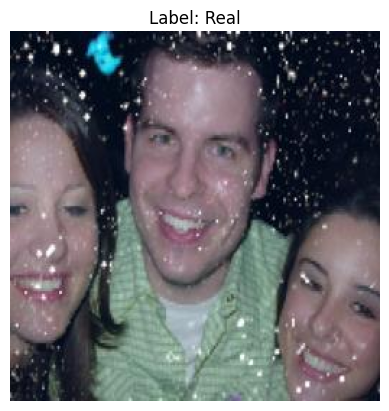

In [ ]:
import matplotlib.pyplot as plt

# Pick one image from training set
example = dataset["test"][9999]
image = example["image"]
label = example["label"]

# Show image
plt.imshow(image)
plt.axis("off")
plt.title(f"Label: {labels[label]}")
plt.show()

In [ ]:
model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
def preprocess(batch):
    # Convert images to model-ready format
    images = [x.convert("RGB") for x in batch["image"]]
    inputs = image_processor(images, return_tensors="np")
    batch["pixel_values"] = inputs["pixel_values"]
    # Remove the original image column
    del batch["image"]
    return batch

In [ ]:
dataset = dataset.with_transform(preprocess)

In [ ]:
data_collator = DefaultDataCollator()

In [ ]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: i for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    prec = precision_score(labels, preds, average="weighted")
    rec = recall_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}

In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 128.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1


In [ ]:
training_args = TrainingArguments(
    output_dir="./vit-deepfake",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,   # if GPU supports mixed precision
    remove_unused_columns=False,
    logging_steps=50,
    save_total_limit=2,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=image_processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-329740850.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.050700,0.111062,0.967713,0.967697,0.968861,0.967713
2,0.028700,0.051739,0.987496,0.987496,0.987496,0.987496


TrainOutput(global_step=17502, training_loss=0.05261815672989587, metrics={'train_runtime': 4050.6383, 'train_samples_per_second': 69.126, 'train_steps_per_second': 4.321, 'total_flos': 2.169806706004422e+19, 'train_loss': 0.05261815672989587, 'epoch': 2.0})

In [ ]:
metrics = trainer.evaluate(dataset["validation"])
print("Validation metrics:", metrics)


test_results = trainer.predict(dataset["test"])
print("Test metrics:", test_results.metrics)

Validation metrics: {'eval_loss': 0.051738668233156204, 'eval_accuracy': 0.9874961955970376, 'eval_f1': 0.9874961920016443, 'eval_precision': 0.9874961998404235, 'eval_recall': 0.9874961955970376, 'eval_runtime': 216.7291, 'eval_samples_per_second': 181.923, 'eval_steps_per_second': 11.374, 'epoch': 2.0}
Test metrics: {'test_loss': 0.3435933291912079, 'test_accuracy': 0.919486474094452, 'test_f1': 0.919137300877807, 'test_precision': 0.926013097881943, 'test_recall': 0.919486474094452, 'test_runtime': 61.1919, 'test_samples_per_second': 178.21, 'test_steps_per_second': 11.145}


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

preds = np.argmax(test_results.predictions, axis=1)
labels = test_results.label_ids

print(classification_report(labels, preds, target_names=dataset["train"].features["label"].names))
print(confusion_matrix(labels, preds))


              precision    recall  f1-score   support

        Fake       0.87      0.98      0.92      5492
        Real       0.98      0.86      0.91      5413

    accuracy                           0.92     10905
   macro avg       0.93      0.92      0.92     10905
weighted avg       0.93      0.92      0.92     10905

[[5392  100]
 [ 778 4635]]


Resolving data files:   0%|          | 0/140002 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/39428 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10905 [00:00<?, ?it/s]

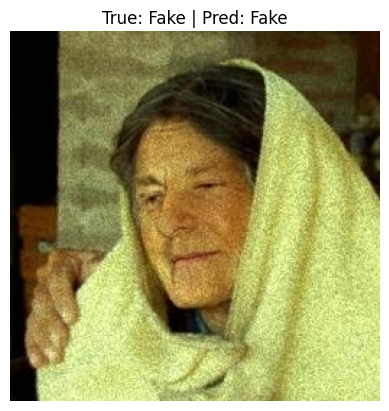

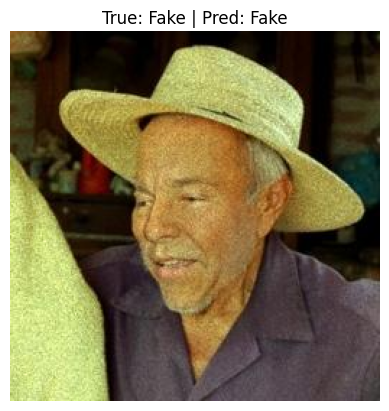

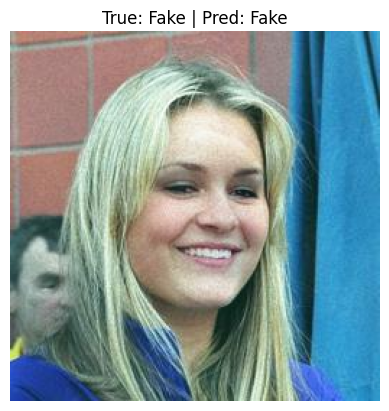

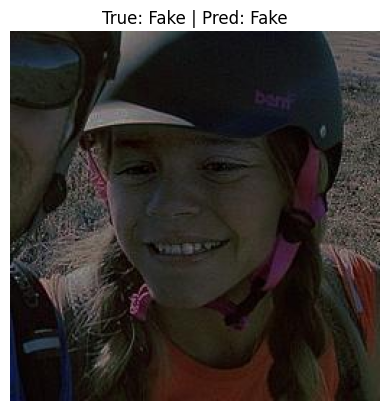

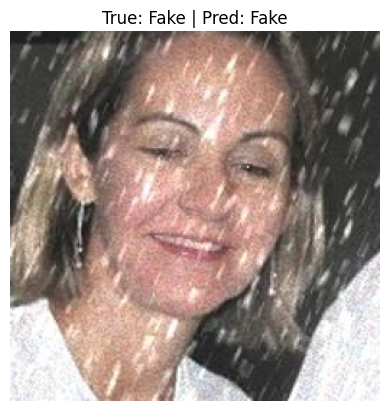

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset


original_dataset = load_dataset("imagefolder", data_dir="/content/deepfake_and_real-images/Dataset")


for i in range(5):

    image = original_dataset["test"][i]["image"]
    label = labels[i]
    pred = preds[i]

    plt.imshow(image)
    plt.title(f"True: {dataset['train'].features['label'].names[label]} | Pred: {dataset['train'].features['label'].names[pred]}")
    plt.axis("off")
    plt.show()

<Figure size 600x600 with 0 Axes>

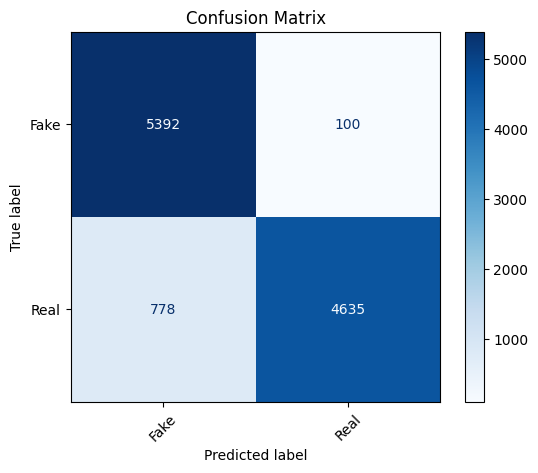

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset["train"].features["label"].names)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
trainer.save_model("./vit-deepfake-3")
